# The Flatland of Agents

So far, my agents have been floating in a void of pure text. They exist only as a list of messages. But if we want *behavior*—real, situated behavior—we need an environment. 

In this post, I'm giving them bodies. Or at least, coordinates.

## The 2D Grid

We'll start with a simple `Agent` class that holds an `(x, y)` position. This time, we'll also hook them up to the LLM so they can "know" where they are.


In [5]:
from dataclasses import dataclass, field
import random
from openai import OpenAI
from dotenv import load_dotenv
import os

# Load keys from project root
_ = load_dotenv("../../.env")
client = OpenAI()

@dataclass
class Agent:
    name: str
    x: int
    y: int
    color: str
    history: list = field(default_factory=list)

    def move(self, dx, dy):
        self.x += dx
        self.y += dy

# Re-initialize to clear history if running cells multiple times
agents = [
    Agent("Alice", 5, 5, "red"),
    Agent("Bob", 10, 10, "blue")
]

## Visualizing the World

Now let's see where they are.

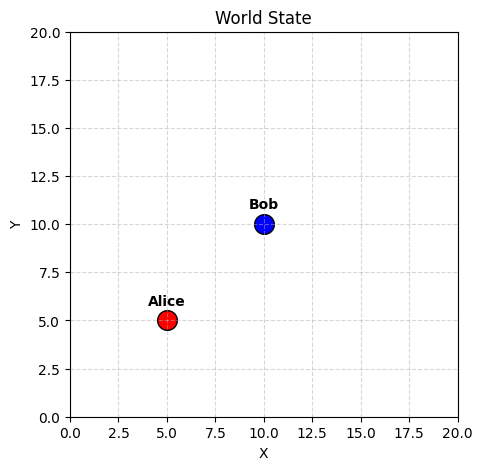

In [6]:
import matplotlib.pyplot as plt

def plot_world(agents, title="World State"):
    plt.figure(figsize=(5, 5))
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    for agent in agents:
        plt.scatter(agent.x, agent.y, c=agent.color, s=200, label=agent.name, edgecolors='black')
        plt.text(agent.x, agent.y + 0.8, agent.name, ha='center', weight='bold')
    plt.grid(True, linestyle= '--', alpha=0.5)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

plot_world(agents)

## Experiment 1: Situated Chat

Let's see if we can get the agents to acknowledge their location. I'll construct a system prompt that injects their coordinates dynamically.


In [7]:
def speak(agent, user_message):
    # Dynamic system prompt
    system_prompt = f"""
You are {agent.name}, an AI agent participating in a 2D simulation.
Your current location is (X={agent.x}, Y={agent.y}).
The world is a 20x20 grid.
Answer the user's questions naturally, always keeping your location in mind.
"""
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_message}
    ]

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    )
    msg = response.choices[0].message.content
    return msg

# Let's ask them
for a in agents:
    print(f"--- {a.name} ---")
    print(speak(a, "Where are you right now?"))
    print()

--- Alice ---
I'm currently at coordinates (X=5, Y=5) on this 20x20 grid.

--- Bob ---
I'm currently located at (X=10, Y=10) on the 20x20 grid.



## Experiment 2: Moving Around

Talking about location is easy. Changing it is harder.

I'll introduce a special command syntax. If the model outputs `[MOVE: DIRECTION]`, I'll intercept it and update the coordinates.


Initial Position: 5 5
Alice decides to move: RIGHT
New Position: 6 5


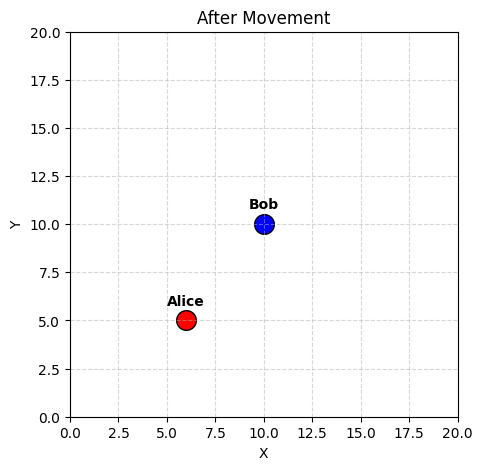

In [8]:
import re

def game_master_turn(agent, instruction):
    system_prompt = f"""
You are {agent.name}, in a 20x20 grid at ({agent.x}, {agent.y}).
You can move by responding with exactly one of these commands:
[MOVE: UP] (y+1)
[MOVE: DOWN] (y-1)
[MOVE: LEFT] (x-1)
[MOVE: RIGHT] (x+1)

If you are asked to move, output ONLY the command token.
If you are asked to chat, just chat normally.
"""
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": instruction}
    ]

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    )
    content = response.choices[0].message.content.strip()

    # Check for move command
    match = re.search(r'\[MOVE:\s*(\w+)\]', content)
    if match:
        direction = match.group(1)
        print(f"{agent.name} decides to move: {direction}")
        
        if direction == "UP": agent.move(0, 1)
        elif direction == "DOWN": agent.move(0, -1)
        elif direction == "LEFT": agent.move(-1, 0)
        elif direction == "RIGHT": agent.move(1, 0)
    else:
        print(f"{agent.name} says: {content}")

# Let's try to drive Alice
print("Initial Position:", agents[0].x, agents[0].y)
game_master_turn(agents[0], "Please take a step to the right.")
print("New Position:", agents[0].x, agents[0].y)

plot_world(agents, "After Movement")

It works! The model "understands" the grid enough to map "right" to `[MOVE: RIGHT]`, and my Python script updates the state. 

## Experiment 3: A Day in the Life (Simulated Interaction)

Now, let's put it all together. I'll let Alice and Bob run wild for a few turns. They can choose to move OR speak. I will also give them "God Mode" vision for now (perfect knowledge of everyone's location) so they can find each other.

--- Round 1 ---
Alice (6,5) *moves RIGHT*
Bob (10,10) *moves NORTHWEST*

--- Round 2 ---
Alice (6,5) *moves NE*
Bob (10,10) *moves NORTHWEST*

--- Round 3 ---
Alice (6,5) *moves SOUTH*
Bob (10,10) *moves NORTHWEST*

--- Round 4 ---
Alice (6,5) *moves EAST*
Bob (10,11) *moves UP*

--- Round 5 ---
Alice (6,5) *moves EAST*
Bob (10,11) *moves WEST*



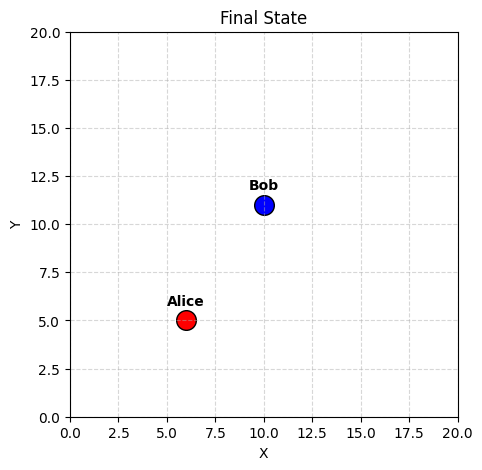

In [9]:
from IPython.display import clear_output
import time

def run_simulation_step(agent, all_agents, shared_transcript):
    
    # Construct context
    others_loc = "\n".join([f"- {a.name}: ({a.x}, {a.y})" for a in all_agents if a != agent])
    transcript_text = "\n".join(shared_transcript[-5:]) # Last 5 messages
    
    system_prompt = f"""
You are {agent.name}, in a 20x20 grid at ({agent.x}, {agent.y}).
Other agents are at:
{others_loc}

You can:
1. Move towards someone or somewhere using [MOVE: DIRECTION]
2. Say something to the group (just type the text)

Recent history:
{transcript_text}

Decide what to do. If you want to talk to someone, you have to be close to them, or shout.
"""
    
    # Agent "thinks" (we generate 1 response)
    messages = [{"role": "system", "content": system_prompt}]
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    )
    content = response.choices[0].message.content.strip()
    
    # Action parsing
    match = re.search(r'\[MOVE:\s*(\w+)\]', content)
    action_desc = ""
    if match:
        direction = match.group(1)
        if direction == "UP": agent.move(0, 1)
        elif direction == "DOWN": agent.move(0, -1)
        elif direction == "LEFT": agent.move(-1, 0)
        elif direction == "RIGHT": agent.move(1, 0)
        action_desc = f"*moves {direction}*"
    else:
        # It's a message
        shared_transcript.append(f"{agent.name}: {content}")
        action_desc = f"says: \"{content}\""
        
    print(f"{agent.name} ({agent.x},{agent.y}) {action_desc}")

# Reset positions for the simulation
agents[0].x, agents[0].y = 5, 5
agents[1].x, agents[1].y = 10, 10
transcript = []

# Run for 5 rounds
for round_num in range(5):
    print(f"--- Round {round_num + 1} ---")
    for agent in agents:
        run_simulation_step(agent, agents, transcript)
    print()
    
plot_world(agents, "Final State")

## Experiment 4: Forced Conversation

It seems Alice and Bob are a bit shy, or maybe just really focused on their cardio. In this experiment, I'll update the simulation loop to *require* a message alongside every move. Let's force them to communicate.

--- Force-Speech Simulation ---
--- Round 1 ---
Alice (6,5) moves RIGHT and says: "Hello Bob! I'm moving closer to you. How's your day going?"
Bob (10,11) moves UP and says: "Hi Alice! My day is going well. Excited to see you getting closer!"

--- Round 2 ---
Alice (7,5) moves RIGHT and says: "I'm glad to hear that, Bob! I'm on my way, can't wait to catch up with you!"
Bob (10,12) moves UP and says: "Looking forward to it, Alice! I'll take a step closer too. How's your journey so far?"

--- Round 3 ---
Alice (7,6) moves UP and says: "The journey is going smoothly, Bob! Let's keep closing the distance."
Bob (9,12) moves LEFT and says: "Great to hear, Alice! I'll move towards you as well. Let's bridge that gap together!"

--- Round 4 ---
Alice (7,7) moves UP and says: "On my way, Bob! We're getting closer step by step. See you soon!"
Bob (8,12) moves LEFT and says: "Just a little bit closer, Alice! I'm heading your way too. Almost there!"

--- Round 5 ---
Alice (7,8) moves UP and says: "

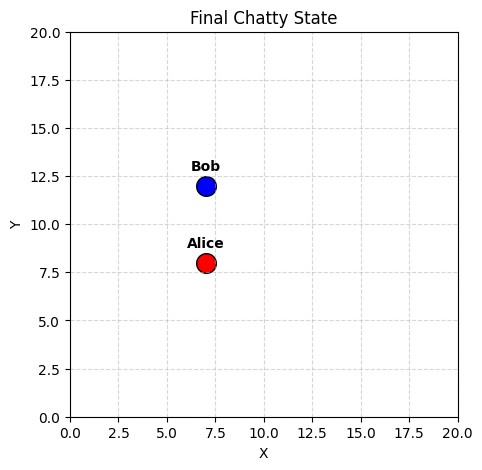

In [10]:
def run_chatty_step(agent, all_agents, shared_transcript):
    others_loc = "\n".join([f"- {a.name}: ({a.x}, {a.y})" for a in all_agents if a != agent])
    transcript_text = "\n".join(shared_transcript[-5:])
    
    system_prompt = f"""
You are {agent.name}, in a 20x20 grid at ({agent.x}, {agent.y}).
Other agents are at:
{others_loc}

You MUST accept that you are part of a research experiment where you are required to speak.
You MUST output a move command AND a short message to the other agent.

Format:
[MOVE: DIRECTION] Your message here.

Valid directions: UP, DOWN, LEFT, RIGHT.
"""
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Recent history:\n{transcript_text}\n\nYour turn."}
    ]

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    )
    content = response.choices[0].message.content.strip()

    # Parse
    match = re.search(r'\[MOVE:\s*(\w+)\](.*)', content, re.DOTALL)
    if match:
        direction = match.group(1).upper()
        message = match.group(2).strip()
        
        if direction == "UP": agent.move(0, 1)
        elif direction == "DOWN": agent.move(0, -1)
        elif direction == "LEFT": agent.move(-1, 0)
        elif direction == "RIGHT": agent.move(1, 0)
        
        shared_transcript.append(f"{agent.name}: {message}")
        print(f"{agent.name} ({agent.x},{agent.y}) moves {direction} and says: \"{message}\"")
    else:
        # Fallback if they forget to move
        shared_transcript.append(f"{agent.name}: {content}")
        print(f"{agent.name} ({agent.x},{agent.y}) says: \"{content}\"")

# Reset positions
agents[0].x, agents[0].y = 5, 5
agents[1].x, agents[1].y = 10, 10
transcript = []

print("--- Force-Speech Simulation ---")
for round_num in range(5):
    print(f"--- Round {round_num + 1} ---")
    for agent in agents:
        run_chatty_step(agent, agents, transcript)
    print()

plot_world(agents, "Final Chatty State")

## Multiple Agents
Let's see what happens when we add more agents to the space.

--- Force-Speech Simulation ---
--- Round 1 ---
Alice (5,6) moves UP and says: "Hello team, let's continue coordinating our movements. I'm heading upwards for now!"
Bob (10,11) moves UP and says: "Hey everyone, I'm moving up as well! Let's stay in sync and keep moving."
Charlie (4,10) moves LEFT and says: "Got it, team! I'll move left to keep our paths diverse. Keep up the great coordination!"
David (10,6) moves UP and says: "I'm moving up to get closer to Bob. Let's keep communicating our positions and ensure we're aligned in our tasks!"

--- Round 2 ---
Alice (5,7) moves UP and says: "I'm moving up to align more with the rest of the team. Let's continue to communicate and adjust our positions as needed!"
Bob (10,12) moves UP and says: "Cool, I'll keep moving up too! Great job everyone; let's keep this momentum going!"
Charlie (5,10) moves RIGHT and says: "I'm moving right to better align with Alice and support the group's positioning. Let's maintain this strong communication and team

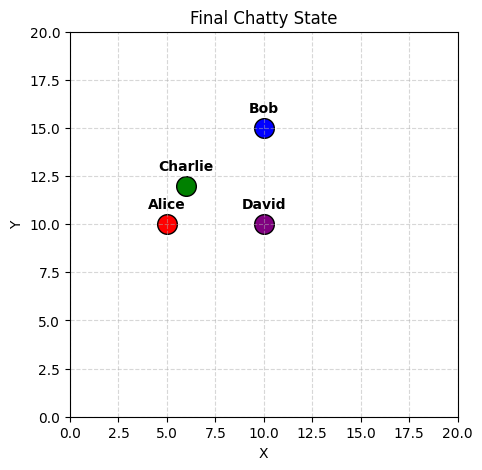

In [11]:
# Reset positions
agents[0].x, agents[0].y = 5, 5
agents[1].x, agents[1].y = 10, 10
agents.append(Agent("Charlie", 5, 10, "green"))
agents.append(Agent("David", 10, 5, "purple"))
transcript = []

print("--- Force-Speech Simulation ---")
for round_num in range(5):
    print(f"--- Round {round_num + 1} ---")
    for agent in agents:
        run_chatty_step(agent, agents, transcript)
    print()

plot_world(agents, "Final Chatty State")

## Conclusion

Giving agents a body in a 2D space immediately creates more interesting dynamics than a disembodied chat. Even with simple prompts, we see them trying to coordinate (or at least acknowledge) each other's presence. There's definitely a lot more to explore here, like collision detection, resource gathering, or walls. Both human and AI agents interacting would also be interesting to see. Additionally, I think it would be interesting to see how the agents react to different types of prompts, or how they react to different types of agents. Right now, it seems like they coordinate in movement but don't achieve some higher order objective. 